<a href="https://colab.research.google.com/github/arteagac/xlogit/blob/master/examples/benchmark/google_colab_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Benchmark in Google Colab

This benchmark compares the estimation speed of `xlogit`, `pylogit` and `biogeme` using a dataset of artificial choices. Make sure that a GPU Hardware Accelerator is being used by clicking `Runtime > Change runtime type`.  To run the entire benchmark simply click `Runtime > Run all`. Let's start by importing some required libraries. 
> <font color='red'>Important: </font> Google Colab may stop the execution when it detects no interaction with this page for too long. To avoid this, try to interact with this page at least every 10 minutes.

In [ ]:
import pandas as pd
import numpy as np
from time import time
import sys, io

rdf = pd.DataFrame(columns=["library", "draws", "time"])  # Dataframe to save results
data_folder = "https://raw.githubusercontent.com/arteagac/xlogit/master/examples/data"

## Part 1: Run benchmark

This benchmark compares the estimation times of `xlogit`, `pylogit`, and `biogeme` at different number of random draws. The results are shown below each execution cells.

### Execute xlogit experiments

In [ ]:
# Install and import xlogit
!pip install xlogit==0.1.0
from xlogit import MixedLogit
MixedLogit.check_if_gpu_available()

1 GPU device(s) available. xlogit will use GPU processing


True

In [ ]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_long.csv")  
varnames = ['price', 'time', 'conven', 'comfort', 'meals', 'petfr',
            'emipp', 'nonsig1', 'nonsig2', 'nonsig3']
X = df[varnames].values
y = df['choice'].values
randvars = {'meals': 'n', 'petfr': 'n', 'emipp': 'n'}
alts = [1, 2, 3]

#### Run estimation using GPU

In [ ]:
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = MixedLogit()
    model.fit(X, y, varnames, alts=alts, n_draws=n_draws, verbose=0, randvars=randvars)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.loglikelihood))
    rdf.loc[len(rdf)] = ['xlogit_gpu', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100    1.35    -2275.85
   200    1.24    -2277.51
   300    1.82    -2280.15


> <font color='red'> Note that the estimation takes less than 2 seconds for xlogit with GPU processing, even for 300 random draws.</font>

#### Run estimation without using GPU

In [ ]:
from xlogit import device
device.disable_gpu_acceleration()

print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = MixedLogit()
    model.fit(X, y, varnames, alts=alts, n_draws=n_draws, verbose=0, randvars=randvars)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.loglikelihood))
    rdf.loc[len(rdf)] = ['xlogit', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100    7.60    -2275.85
   200   14.17    -2277.51
   300   21.61    -2280.15


> <font color='red'> Note that withouth using a GPU, the estimation time increases. </font> 

### Execute pylogit experiments

In [ ]:
# Install and import pylogit
!pip install pylogit==0.2.2
import pylogit as pl
from collections import OrderedDict
import warnings
# Disable warnings shown by pylogit to better visualize the benchmark outputs
warnings.filterwarnings('ignore') 

     |████████████████████████████████| 194kB 16.5MB/s 


In [ ]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_long.csv")  
varnames = ['price', 'time', 'conven', 'comfort', 'meals', 'petfr',
            'emipp', 'nonsig1', 'nonsig2', 'nonsig3']
alt_id_col = "alt"
obs_id_col = "id"
choice_col = "choice"
mixing_id_col = "id"
mixing_vars = ["meals", "petfr", "emipp"]
spec, spec_names = OrderedDict(), OrderedDict()
for col in varnames:
    df[col] = df[col].astype(float)
    spec[col] = [[1, 2, 3]]
    spec_names[col] = [col]

# Run estimation
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    np.random.seed(0)
    start_time = time()
    model = pl.create_choice_model(data=df, alt_id_col=alt_id_col,
                                obs_id_col=obs_id_col, choice_col=choice_col,
                                specification=spec, mixing_vars=mixing_vars,
                                model_type="Mixed Logit", names=spec_names,
                                mixing_id_col=mixing_id_col)
    model.fit_mle(init_vals=np.zeros(len(varnames)+len(mixing_vars)),
                num_draws=n_draws, seed=123, print_res=False)
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, model.log_likelihood))
    rdf.loc[len(rdf)] = ['pylogit', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100   72.12    -2283.39
   200  135.00    -2285.38
   300  103.07    -2273.75


> <font color='red'> Note that the estimation times of `pylogit` are substantially larger compared to `xlogit` with gpu processing.</font>

### Execute biogeme experiments

For this experiment, `biogeme` will run using two processor cores. 

In [ ]:
# Install and import biogeme
!pip install biogeme==3.2.6
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as msg
from biogeme.expressions import Beta, bioDraws, log, MonteCarlo

     |████████████████████████████████| 1.1MB 21.2MB/s 
     |████████████████████████████████| 245kB 49.7MB/s 
  Created wheel for biogeme: filename=biogeme-3.2.6-cp36-cp36m-linux_x86_64.whl size=3180740 sha256=e2d0c78dabb21ef7ec62185ff21eccbdd97baa2cde36e84f25a000565e301226
  Stored in directory: /root/.cache/pip/wheels/a9/5e/40/84c8872ea823cc88e8033bc4a27fe8b71c65453949159b3aa1
Successfully built biogeme


In [ ]:
# Prepare input data
df = pd.read_csv(data_folder+"/artificial_wide.csv")
df['choice'] = df['choice'].astype('str')
mapping = {'1': 1, '2': 2, '3': 3}

for k, v in mapping.items():
    df["aval_"+k] = np.ones(df.shape[0])
df = df.replace({'choice': mapping})
database = db.Database('artificial', df)

globals().update(database.variables)

# Fixed params
b_price = Beta('b_price', 0, None, None, 0)
b_time = Beta('b_time', 0, None, None, 0)
b_conven = Beta('b_conven', 0, None, None, 0)
b_comfort = Beta('b_comfort', 0, None, None, 0)
b_nonsig1 = Beta('b_nonsig1', 0, None, None, 0)
b_nonsig2 = Beta('b_nonsig2', 0, None, None, 0)
b_nonsig3 = Beta('b_nonsig3', 0, None, None, 0)

# Random params
u_meals = Beta('u_meals', 0, None, None, 0)
u_petfr = Beta('u_petfr', 0, None, None, 0)
u_emipp = Beta('u_emipp', 0, None, None, 0)
sd_meals = Beta('sd_meals', 0, None, None, 0)
sd_petfr = Beta('sd_petfr', 0, None, None, 0)
sd_emipp = Beta('sd_emipp', 0, None, None, 0)

b_meals = u_meals + sd_meals*bioDraws('b_meals', 'NORMAL')
b_petfr = u_petfr + sd_petfr*bioDraws('b_petfr', 'NORMAL')
b_emipp = u_emipp + sd_emipp*bioDraws('b_emipp', 'NORMAL')

V1 = price_1*b_price+time_1*b_time+conven_1*b_conven+comfort_1*b_comfort+\
    meals_1*b_meals+petfr_1*b_petfr+emipp_1*b_emipp+nonsig1_1*b_nonsig1+\
        nonsig2_1*b_nonsig2+nonsig3_1*b_nonsig3
V2 = price_2*b_price+time_2*b_time+conven_2*b_conven+comfort_2*b_comfort+\
    meals_2*b_meals+petfr_2*b_petfr+emipp_2*b_emipp+nonsig1_2*b_nonsig1+\
        nonsig2_2*b_nonsig2+nonsig3_2*b_nonsig3
V3 = price_3*b_price+time_3*b_time+conven_3*b_conven+comfort_3*b_comfort+\
    meals_3*b_meals+petfr_3*b_petfr+emipp_3*b_emipp+nonsig1_3*b_nonsig1+\
        nonsig2_3*b_nonsig2+nonsig3_3*b_nonsig3

V = {1: V1, 2: V2, 3: V3}
av = {1: aval_1, 2: aval_2, 3: aval_3}

prob = models.logit(V, av, choice)
logprob = log(MonteCarlo(prob))

# Define level of verbosity
logger = msg.bioMessage()
logger.setSilent()

# Run estimation
print("Ndraws Time(s) Log-Likeli.")
for n_draws in [100, 200, 300]:
    start_time = time()
    biogeme = bio.BIOGEME(database, logprob, numberOfDraws=n_draws, numberOfThreads=2)
    biogeme.modelName = 'MixedLogitArtificial'
    biogeme.generateHtml = False
    biogeme.generatePickle = False
    results = biogeme.estimate()
    ellapsed = time() - start_time
    print("{:6} {:7.2f} {:11.2f}".format(n_draws, ellapsed, results.data.logLike))
    rdf.loc[len(rdf)] = ['biogeme', n_draws, ellapsed]

Ndraws Time(s) Log-Likeli.
   100  417.89    -2290.37
   200  651.30    -2277.82
   300 1084.33    -2279.25


> <font color='red'> Note that the estimation times of `biogeme` are substantially larger compared to `xlogit` with gpu processing.</font>

## Part 2: Plot benchmark results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.spines.right': False,
                            'axes.spines.top': False})
markers = ['^', 'd', 'x', 'o', '^', '|']
colors = [ "#984ea3", "#377eb8", "#ff7f00", "#e41a1c", "#984ea3",
          "#a4c500"]
libs = ['biogeme', 'pylogit', 'xlogit', 'xlogit_gpu']

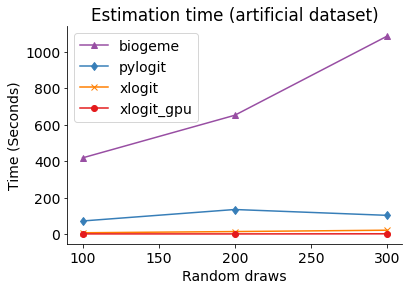

In [ ]:
# Plot time benchmark
plt.figure()
for i, lib in enumerate(libs):
    d = rdf[rdf.library == lib][["draws", "time"]].values.T
    plt.plot(d[0], d[1], marker=markers[i], c=colors[i])
plt.legend(libs)
plt.xlabel("Random draws")
plt.ylabel("Time (Seconds)")
plt.title("Estimation time (artificial dataset)")
plt.show()

> <font color='red'> This figure resembles to some degree the results in Figures 1 and 2 in the paper </font>

**<font color='red'>The benchmark results indicate that `xlogit_gpu` is significantly faster than `pylogit` and `biogeme`</font>**. The plot seems to suggest that `xlogit_gpu` and `pylogit` have a similar performance; however, note that the units in the `y` axis are in terms of hundreds. For instance, note that for 300 draws, `xlogit_gpu` takes less than two seconds whereas `pylogit` takes around 100 seconds. The next section presents a more convenient summary of the speed gains provided by `xlogit` in the form of a comparison table.

## Part 3: Show comparison table

In [ ]:
dfc = rdf.pivot(index='library', columns='draws', values='time')

# Compute estimation time compared to xlogit_gpu
for draws in [100, 200, 300]:
    col = dfc[draws]
    dfc['c'+str(draws)] = col.values/col[col.index == "xlogit_gpu"].values
dfc['cavg'] = dfc[['c'+str(i) for i in [100, 200, 300]]].values.mean(axis=1)
dfc = dfc.round(1)

# Print in a table format
print("\n\n********* TABLE COMPARISON ESTIMATION TIME *********\n")
print("{:12} {:^23} {:^23}".format("", "Estimation time", "Compared to xlogit_gpu"))
c = dfc.columns.values
print("{:12} {:6} {:6} {:6} {:>6} {:>6} {:>6} {:>6}".format(
    "draws-->", c[0], c[1], c[2], c[3], c[4], c[5], "c_avg"))
for row in dfc.iterrows():
    c = row[1].values
    print("{:12} {:6} {:6} {:6} {:6} {:6} {:6} {:6}".format(
        row[0], c[0], c[1], c[2], c[3], c[4], c[5], c[6]))



********* TABLE COMPARISON ESTIMATION TIME *********
                 Estimation time     Compared to xlogit_gpu 
draws-->        100    200    300   c100   c200   c300  c_avg
biogeme       417.9  651.3 1084.3  310.6  524.5  595.0  476.7
pylogit        72.1  135.0  103.1   53.6  108.7   56.6   73.0
xlogit          7.6   14.2   21.6    5.6   11.4   11.9    9.6
xlogit_gpu      1.3    1.2    1.8    1.0    1.0    1.0    1.0


> <font color='red'>  Note that this table resembles to some degree the results in Table 3 in the paper </font>

The first set of columns in the table summarize the different estimation times and the second set of columns compare such estimation times against the ones yielded by `xlogit_gpu`. The final column shows how slow the other tools are compared to `xlogit_gpu`. Note that, in average, `xlogit` with GPU processing is around 73x faster than `pylogit`, 467x faster than `biogeme` (which used 2 processor cores simultaneously), and 9x faster thatn `xlogit` without GPU processing. 

## Part 4: Show `xlogit` tables of estimates

The following tables show the estimates obtained with `xlogit` for the artificial, electricity, and fishing datasets.

> <font color='red'> Note that the estimates below are the exact same estimates for `xlogit` in the paper (Tables 1 and 2). </font> The results for `mlogit` can't be shown here because Google Colab does not run R code. Also, the extensive estimation times of `pylogit` make it difficult to show the complete results in this quick benchmark in Google Colab. However, the results can be entirely replicated using the mini and full benchmark.

### Artificial dataset

In [ ]:
device.enable_gpu_acceleration()
df = pd.read_csv(data_folder+"/artificial_long.csv")  
varnames = ['price', 'time', 'conven', 'comfort', 'meals', 'petfr',
            'emipp', 'nonsig1', 'nonsig2', 'nonsig3']

np.random.seed(0)
model = MixedLogit()
model.fit(X=df[varnames], y=df['choice'], varnames=varnames, alts=df['alt'],
          ids=df['id'], randvars={'meals': 'n', 'petfr': 'n', 'emipp': 'n'},
          n_draws=400)
model.summary()

Estimation with GPU processing enabled.
Optimization terminated successfully.
         Current function value: 2276.975676
         Iterations: 53
         Function evaluations: 69
         Gradient evaluations: 69
Estimation time= 2.7 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                  -1.0619123     0.1656002    -6.4125057      1.04e-09 ***
time                   -1.4945887     0.1684276    -8.8737748      9.22e-18 ***
conven                  0.9191472     0.1410970     6.5142948      5.41e-10 ***
comfort                 1.1083482     0.1809920     6.1237430      6.23e-09 ***
meals                   1.7412874     0.2109908     8.2529071      1.71e-15 ***
petfr                   4.0055383     0.3967163    10.0967321      1.09e-22 ***
emipp                  -2.1052121     0.2333379 

### Electricity dataset

In [ ]:
df = pd.read_csv(data_folder+"/electricity_long.csv")
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']

np.random.seed(0)
model = MixedLogit()
model.fit(X=df[varnames], y=df['choice'], varnames=varnames, alts=df['alt'],
          ids=df['chid'], panels=df['id'], randvars={'pf': 'n', 'cl': 'n',
          'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'}, n_draws=600)
model.summary()

Estimation with GPU processing enabled.
Optimization terminated successfully.
         Current function value: 3888.413414
         Iterations: 46
         Function evaluations: 51
         Gradient evaluations: 51
Estimation time= 6.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
pf                     -0.9996286     0.0331488   -30.1557541     9.98e-100 ***
cl                     -0.2355334     0.0220401   -10.6865870      1.97e-22 ***
loc                     2.2307891     0.1164263    19.1605300      5.64e-56 ***
wk                      1.6251657     0.0918755    17.6887855      6.85e-50 ***
tod                    -9.6067367     0.3112721   -30.8628296     2.36e-102 ***
seas                   -9.7892800     0.2913063   -33.6047603     2.81e-112 ***
sd.pf                   0.2357813     0.0181892 

### Fishing dataset

In [ ]:
df = pd.read_csv(data_folder+"/fishing_long.csv")
X = df[['price', 'catch']]
y = df['choice']

np.random.seed(0)
model = MixedLogit()
model.fit(X, y,  varnames=['price', 'catch'], alts=df['alt'], ids=df['id'],
          randvars={'price': 'n', 'catch': 'n'}, n_draws=1000)
model.summary()

Estimation with GPU processing enabled.
Optimization terminated successfully.
         Current function value: 1300.511342
         Iterations: 42
         Function evaluations: 55
         Gradient evaluations: 55
Estimation time= 1.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
price                  -0.0272460     0.0022981   -11.8561003      1.09e-29 ***
catch                   1.3271142     0.1743127     7.6134088      4.01e-13 ***
sd.price                0.0102129     0.0021859     4.6722496      1.59e-05 ***
sd.catch               -1.5706821     0.3762576    -4.1744858      0.000139 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -1300.511
AIC= 2609.023
BIC= 2629.323
